In [1]:

import torch.nn as nn
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

C:\Users\Will_\miniconda3\envs\csc413\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Step1 Load the data**

In [2]:
import dataloader
creature_imgs, creature_captions =dataloader.get_torch_creature_data() 

## **Step2 Process the data**
Turn both the image and captions in to embeddings,\
For images we are using **VGG16** to obtain the features
For captions we are using Character by character **onehot** embeddings

* Character by character Onehot embedding

In [10]:
# use { and } as start of the sentence and end of sentence
# use @ as padding
def get_character_vocab(sentences):
    return list(set([i for sentence in sentences for word in sentence.lower() for i in word] ))+ ["{", "}"] + ["@"]
    

In [11]:
vocab = get_character_vocab(creature_captions)

In [5]:
vocab_stoi = {vocab[i] :i for i in range(len(vocab))}
vocab_itos = {i:vocab[i] for i in range(len(vocab))}    

In [12]:
def make_torch_token(sentences, vocab):
    tokens = []
    for sentence in sentences:
        token = [vocab_stoi["{"]] + [vocab_stoi[character] for character in sentence.lower()] + [vocab_stoi["}"]]
        tokens.append(token)
    return np.array(tokens)

In [13]:
def make_onehot(tokens,vocab):
    
    word_onehot = torch.eye(len(vocab))
    onehot_sentences = []
    for token in tokens:
        torch_onehot_sentence = word_onehot[token.int().tolist()]
        onehot_sentences.append(torch_onehot_sentence.unsqueeze(0))
    
    return onehot_sentences

In [104]:
def get_sentence_from_onehot(sentences, vocab):
    readable_sentences = []
    for sentence in sentences:
        readable_sentence = [vocab[torch.argmax(character)] for character in sentence]
    
        readable_sentences.append(readable_sentence)
         
    return readable_sentences

In [15]:
token_creature_captions = make_torch_token(creature_captions,vocab)

C:\Users\Will_\AppData\Local\Temp\ipykernel_105440\3107438979.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(tokens)


In [16]:
small_token_creature_captions = token_creature_captions[:5]

In [17]:
padded = pad_sequence([torch.Tensor(i) for i in small_token_creature_captions],padding_value=vocab_stoi["@"],batch_first=True)

In [91]:
def get_padded_onehot_from_token(tokens):
    
    word_onehot = torch.eye(len(vocab))
    onehot_sentences=[]
    padded_tokens = pad_sequence(tokens,padding_value=vocab_stoi["@"],batch_first=True)
    for token in padded_tokens:
        
        torch_onehot_sentence = word_onehot[token.int().tolist()]
        onehot_sentences.append(torch_onehot_sentence.unsqueeze(0))
    return torch.cat(onehot_sentences)

    

* VGG16

        Load VGG16 

In [21]:
vgg = torchvision.models.vgg16(pretrained=True)


        Get the features from VGG16

In [22]:
features = vgg.features(creature_imgs[0:5])

In [23]:
class PositionalEncoding(nn.Module):
    def __init__(self,dropout_rate, input_dimensions,max_sequence_len, dimension2d=False):
        super(PositionalEncoding,self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        
        positional_embedding = torch.zeros(input_dimensions,max_sequence_len)
        even = torch.arange(0,input_dimensions,2)
        odd = torch.arange(1,input_dimensions,2)
        position = torch.arange(max_sequence_len)
        denominator = torch.float_power(10000,even/input_dimensions)
        positional_embedding[0::2] = torch.sin(position.unsqueeze(0)/denominator.unsqueeze(1))
        positional_embedding[1::2] = torch.cos(position.unsqueeze(0)/denominator.unsqueeze(1))
        horizontal_positional_embedding = positional_embedding
        vertical_positional_embedding = positional_embedding
        if dimension2d:
            positional_embedding = horizontal_positional_embedding.unsqueeze(1) + vertical_positional_embedding.unsqueeze(2)
        else:
            positional_embedding = horizontal_positional_embedding.permute(1,0)
        self.register_buffer("positional_embedding",positional_embedding)
        
        
    def forward(self,x):
        if len(x.shape) == 3:
            
            x = x + self.positional_embedding[:x.shape[1],:].unsqueeze(0)
        else:
            x = x + self.positional_embedding[:,:x.shape[2],:x.shape[3]].unsqueeze(0)
        return self.dropout(x)       
        
        
        

In [315]:
class caption_transformer(nn.Module):
    def __init__(self,num_heads,max_sequence_len):
        super(caption_transformer,self).__init__()
        
        
        self.cnn_layer = nn.Conv2d(512,128,1)
        self.fc_layer = nn.Linear(51,128)      
        self.transformer_layer = nn.Transformer(128,num_heads,batch_first=True,num_encoder_layers=2,num_decoder_layers=2)  

        self.fc_layer2 = nn.Linear(128,128)
        self.fc_layer3 = nn.Linear(128,51)
        self.source_positional_embedding = PositionalEncoding(0.1,128,7,dimension2d=True)
        self.target_positional_embedding = PositionalEncoding(0.1,128,max_sequence_len=max_sequence_len)
        
    def forward(self, inp, target,mask=True):
        # embed the image
        emb_inp = self.cnn_layer(inp)
        # positional embedding for source
        emb_inp = self.source_positional_embedding(emb_inp)
        # embed the text
        emb_target = self.fc_layer(target)
        # positional embedding for target
        emb_target = self.target_positional_embedding(emb_target) if mask else emb_target
        N = emb_inp.shape[0]
        dim = emb_inp.shape[1] 
        emb_inp = emb_inp.view(N,dim,-1)
        emb_inp = torch.transpose(emb_inp, 1,2)
        
        tgt_mask = self.make_tgt_mask(target) if mask else None
            
        
        out = self.transformer_layer(emb_inp,emb_target,tgt_mask=tgt_mask)
        out = self.fc_layer2(out)
        out = self.fc_layer3(out)

        return out
        
    def make_tgt_mask(self,tgt):
        M, N, tgt_len = tgt.shape
        tgt_mask = torch.tril(torch.ones((N,N)) ==1)
        tgt_mask = tgt_mask.float()
        tgt_mask = tgt_mask.masked_fill(tgt_mask==0, float('-inf'))
        tgt_mask = tgt_mask.masked_fill(tgt_mask ==1, float(0.0)) 
        return tgt_mask
        
        

In [26]:
class My_Dataset(torch.utils.data.Dataset):
    def __init__(self, source, target):
        self.datasetA = source
        self.datasetB = target
    
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    
    def __len__(self):
        return len(self.datasetA)

In [39]:
target = token_creature_captions[:5]

In [40]:
creature_dataset = My_Dataset(features,target)

In [41]:
def get_accuracy(model, data,batch_size = 100):
    mini_batch = batcher(data,batch_size)
    num = 0
    correct = 0
    for x,tokens in mini_batch:
        y = get_padded_onehot_from_token([torch.Tensor(i) for i in tokens])
        N, S, W = y.shape 
        num+=N*S
        out = model(x,y[:,:-1,:])
        correct += torch.sum(torch.argmax(out,2) == torch.argmax(y[:,1:,:],2))
    return correct/num

In [42]:
def batcher(data,batch_size):
    
    new = []
    index = 0
    indexes = np.arange(len(data))
    np.random.shuffle(indexes)
    while index < len(data):
        new.append(data[indexes[index:index+batch_size]])
        index+= batch_size
    return new
        

In [126]:
def train(model, train_data,valid_data, num_epoches=10, batch_size=30, learning_rate = 0.1, weight_decay = 0):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr = learning_rate, weight_decay=weight_decay)
    train_accs, val_accs  = [], [] 
    iters, losses = [], []
    n=0
    for epoch in range(num_epoches):
        mini_batch = batcher(train_data, batch_size=batch_size)
        num_update = 0
      
        for x,tokens in mini_batch:  
            model.train()
            num_update += 1
            
            t = get_padded_onehot_from_token([torch.Tensor(i) for i in tokens])
            
            y = model(x,t[:,:-1,:])
            loss = criterion(y,t[:,1:,:])
            loss.backward(retain_graph= True)
            optimizer.step()
            optimizer.zero_grad()
            
            train_cost = float(loss.detach().numpy())
            train_acc = get_accuracy(model, train_data)
            val_acc = get_accuracy(model, valid_data)
            n+=1
            iter = n
            print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                        iter, val_acc * 100, train_acc * 100, train_cost))
            iters.append(n)
            losses.append(loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
        
    plt.title("Training curve")
    plt.plot(iters, train_accs, label = "Train")
    plt.plot(iters, val_accs, label = "Valid")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [328]:
def generate_captions(source,model):
    
    start = torch.Tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]])

    temp = start
    for i in range(200):

        inter = model(source.unsqueeze(0),temp)
        combine = torch.cat((temp,inter[:,-1,:].unsqueeze(0)),dim=1)
        #temp = combine
        temp = emphesis(combine)
    readable = get_sentence_from_onehot(temp,vocab)
    return readable

In [349]:
valid_features = vgg.features(creature_imgs[:1000])
valid_caption = token_creature_captions[:1000]
valid_dataset = My_Dataset(valid_features,valid_caption)

In [59]:
tiny_features = vgg.features(creature_imgs[:1])
tiny_captions = token_creature_captions[:1]
tiny_train_data = My_Dataset(tiny_features,tiny_captions)

In [258]:
small_features = vgg.features(creature_imgs[:5])
small_captions = token_creature_captions[:5]
small_train_data = My_Dataset(small_features,small_captions)

In [347]:
big_features = vgg.features(creature_imgs[:20])
big_captions = token_creature_captions[:20]
big_train_data = My_Dataset(big_features,big_captions)

In [350]:
big_transformer = caption_transformer(8,200)

Iter 1. [Val Acc 28%] [Train Acc 84%, Loss 5.054904]
Iter 2. [Val Acc 28%] [Train Acc 86%, Loss 4.552799]
Iter 3. [Val Acc 31%] [Train Acc 84%, Loss 2.220362]
Iter 4. [Val Acc 25%] [Train Acc 81%, Loss 5.279661]
Iter 5. [Val Acc 26%] [Train Acc 80%, Loss 3.196465]
Iter 6. [Val Acc 28%] [Train Acc 83%, Loss 4.881677]
Iter 7. [Val Acc 28%] [Train Acc 84%, Loss 2.925806]
Iter 8. [Val Acc 31%] [Train Acc 84%, Loss 5.424734]
Iter 9. [Val Acc 29%] [Train Acc 85%, Loss 4.730721]
Iter 10. [Val Acc 22%] [Train Acc 83%, Loss 5.144475]
Iter 11. [Val Acc 28%] [Train Acc 82%, Loss 4.865522]
Iter 12. [Val Acc 27%] [Train Acc 82%, Loss 3.892762]
Iter 13. [Val Acc 24%] [Train Acc 83%, Loss 5.103099]
Iter 14. [Val Acc 30%] [Train Acc 84%, Loss 3.662247]
Iter 15. [Val Acc 24%] [Train Acc 86%, Loss 4.964935]
Iter 16. [Val Acc 30%] [Train Acc 85%, Loss 3.318021]
Iter 17. [Val Acc 28%] [Train Acc 87%, Loss 5.146041]
Iter 18. [Val Acc 26%] [Train Acc 87%, Loss 4.474965]
Iter 19. [Val Acc 24%] [Train Acc 87%

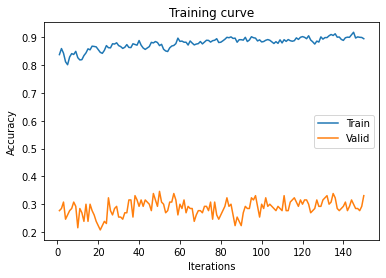

In [353]:

train(big_transformer,big_train_data,valid_dataset,50,learning_rate=0.0005,batch_size=7)

In [390]:
def describe(n, model):
    feature = vgg.features(creature_imgs[n:n+1])
    
    out = generate_captions(feature[0],model)
    plt.imshow(creature_imgs[n].int().permute(1,2,0))
    print(''.join(out[0]))
    

{a could dog p coperer je prurombmthe ,fxxklety}@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


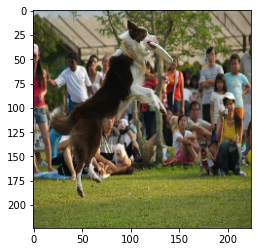

In [395]:
describe(100,big_transformer)

In [396]:
creature_captions[100]

'A black and white Border Collie catches a Frisbee in front of an audience '

In [147]:
start = torch.Tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]])


In [228]:
def emphesis(onehot):
    temp = torch.argmax(onehot,dim = 2)
    return get_padded_onehot_from_token([i for i in temp])

In [538]:
tiny_transformer =  caption_transformer(8,200)
train(tiny_transformer,tiny_train_data,tiny_train_data,learning_rate=0.001,num_epoches=100,batch_size=30,)

tensor([[[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        [[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]])


RuntimeError: each element in list of batch should be of equal size

In [66]:

out = tiny_transformer(features[0].unsqueeze(0), target[0].unsqueeze(0)[:,:-1,:])

In [67]:
creature_imgs[0].shape

torch.Size([3, 224, 224])

'a child in a pink dress is climbing up a set of stairs in a  entry way }@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@'

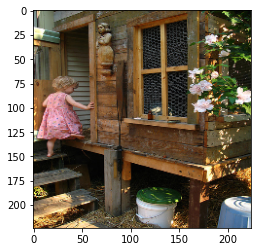

In [68]:
plt.imshow(creature_imgs[0].permute(1,2,0).int())
sentence = get_sentence_from_onehot(out,vocab)
''.join(sentence[0])

Iter 1. [Val Acc 53%] [Train Acc 54%, Loss 17.475039]
Iter 2. [Val Acc 21%] [Train Acc 24%, Loss 17.038582]
Iter 3. [Val Acc 65%] [Train Acc 65%, Loss 16.981627]
Iter 4. [Val Acc 66%] [Train Acc 67%, Loss 16.650639]
Iter 5. [Val Acc 69%] [Train Acc 68%, Loss 16.365370]
Iter 6. [Val Acc 69%] [Train Acc 69%, Loss 16.060644]
Iter 7. [Val Acc 69%] [Train Acc 69%, Loss 15.868306]
Iter 8. [Val Acc 72%] [Train Acc 71%, Loss 15.651612]
Iter 9. [Val Acc 70%] [Train Acc 71%, Loss 15.553219]
Iter 10. [Val Acc 71%] [Train Acc 72%, Loss 15.548039]
Iter 11. [Val Acc 68%] [Train Acc 68%, Loss 15.399825]
Iter 12. [Val Acc 69%] [Train Acc 69%, Loss 15.569022]
Iter 13. [Val Acc 72%] [Train Acc 72%, Loss 15.476325]
Iter 14. [Val Acc 71%] [Train Acc 71%, Loss 15.185826]
Iter 15. [Val Acc 71%] [Train Acc 71%, Loss 15.356575]
Iter 16. [Val Acc 71%] [Train Acc 72%, Loss 15.458107]
Iter 17. [Val Acc 71%] [Train Acc 71%, Loss 15.116787]
Iter 18. [Val Acc 71%] [Train Acc 72%, Loss 15.062333]
Iter 19. [Val Acc 7

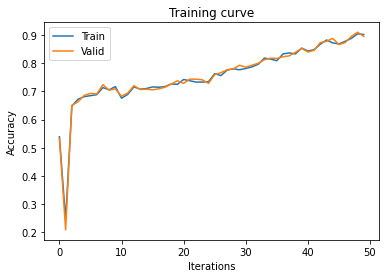

In [64]:
small_transformer = caption_transformer(8)
train(small_transformer,small_train_data,small_train_data,learning_rate=0.001,num_epoches=50)

Iter 1. [Val Acc 77%] [Train Acc 76%, Loss 13.192142]
Iter 2. [Val Acc 79%] [Train Acc 79%, Loss 14.188063]
Iter 3. [Val Acc 85%] [Train Acc 82%, Loss 13.972493]
Iter 4. [Val Acc 86%] [Train Acc 87%, Loss 13.641713]
Iter 5. [Val Acc 88%] [Train Acc 88%, Loss 13.412138]
Iter 6. [Val Acc 88%] [Train Acc 89%, Loss 13.382388]
Iter 7. [Val Acc 89%] [Train Acc 88%, Loss 13.268505]
Iter 8. [Val Acc 89%] [Train Acc 88%, Loss 13.216901]
Iter 9. [Val Acc 89%] [Train Acc 88%, Loss 13.160680]
Iter 10. [Val Acc 90%] [Train Acc 89%, Loss 13.164543]
Iter 11. [Val Acc 90%] [Train Acc 89%, Loss 13.063646]
Iter 12. [Val Acc 91%] [Train Acc 91%, Loss 13.041174]
Iter 13. [Val Acc 92%] [Train Acc 94%, Loss 12.967552]
Iter 14. [Val Acc 93%] [Train Acc 92%, Loss 13.007338]
Iter 15. [Val Acc 94%] [Train Acc 93%, Loss 12.902250]
Iter 16. [Val Acc 94%] [Train Acc 95%, Loss 12.915670]
Iter 17. [Val Acc 95%] [Train Acc 95%, Loss 12.871367]
Iter 18. [Val Acc 94%] [Train Acc 94%, Loss 12.833856]
Iter 19. [Val Acc 9

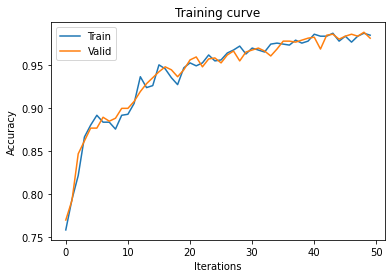

In [70]:
train(small_transformer,small_train_data,small_train_data,learning_rate=0.001,num_epoches=50)

In [110]:
get_accuracy(small_transformer,small_train_data)

tensor(0.9805)

In [40]:
big_features = vgg.features(creature_imgs[:50])
big_captions = onehot_creature_captions[:50]

In [41]:
big_dataset = My_Dataset(big_features,big_captions)

In [42]:
big_valid_features = vgg.features(creature_imgs[210:260])
big_valid_captions = onehot_creature_captions[210:260]

In [43]:
valid_dataset = My_Dataset(big_valid_features,big_valid_captions)

In [81]:
lengths =[len(s) for s in creature_captions]

In [84]:
np.mean(lengths)

54.62588060808306

In [134]:
features.shape

torch.Size([5, 512, 7, 7])

In [135]:
batch_small_data = My_Dataset(features, small_onehot)

In [332]:
batch_small_transformer = caption_transformer(8,200)

Iter 1. [Val Acc 39%] [Train Acc 40%, Loss 5.065861]
Iter 2. [Val Acc 45%] [Train Acc 45%, Loss 6.590755]
Iter 3. [Val Acc 55%] [Train Acc 55%, Loss 6.030525]
Iter 4. [Val Acc 66%] [Train Acc 66%, Loss 5.591172]
Iter 5. [Val Acc 74%] [Train Acc 72%, Loss 5.376793]
Iter 6. [Val Acc 78%] [Train Acc 78%, Loss 5.218435]
Iter 7. [Val Acc 76%] [Train Acc 77%, Loss 5.181398]
Iter 8. [Val Acc 75%] [Train Acc 75%, Loss 5.188625]
Iter 9. [Val Acc 76%] [Train Acc 76%, Loss 5.089996]
Iter 10. [Val Acc 76%] [Train Acc 78%, Loss 5.094921]
Iter 11. [Val Acc 81%] [Train Acc 80%, Loss 5.013790]
Iter 12. [Val Acc 83%] [Train Acc 80%, Loss 5.019691]
Iter 13. [Val Acc 82%] [Train Acc 82%, Loss 4.975700]
Iter 14. [Val Acc 81%] [Train Acc 83%, Loss 4.894450]
Iter 15. [Val Acc 83%] [Train Acc 83%, Loss 4.885895]
Iter 16. [Val Acc 86%] [Train Acc 85%, Loss 4.848498]
Iter 17. [Val Acc 85%] [Train Acc 86%, Loss 4.780190]
Iter 18. [Val Acc 87%] [Train Acc 85%, Loss 4.794127]
Iter 19. [Val Acc 85%] [Train Acc 86%

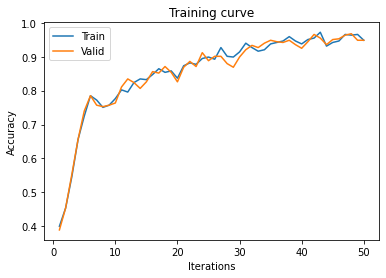

In [334]:
train(batch_small_transformer,batch_small_data,batch_small_data,50,learning_rate=0.001)

In [350]:
out = batch_small_transformer(features[0].unsqueeze(0), small_onehot[0].unsqueeze(0)[:,:-1,:])

In [357]:
index_out = torch.argmax(out,dim =2).tolist()

In [362]:
numpy_vocab = np.array(vocab)

In [364]:
''.join(numpy_vocab[index_out[0]])

'a child in a pink dress is climbing up a set of stairs in an entry wyy }@@@@@@@@@@@@@@@@@@@@'

In [367]:
out = generate_captions(features[0],batch_small_transformer)

In [368]:
''.join(out[0])

'{aym meneinenb m iog w w w w mhild g m w wog m m weilw w m m weilw w g w w w w w g m w whwow d m m w w w g m iow w m w g w g m w w w g g w w w m g g w g g m g w w w w w w w g w g g w g g m whwhw w m w '

In [330]:
out = generate_captions(features[0], batch_small_transformer)

In [331]:
''.join(out[0])

'{@nanenenenan nenenen nenenenenemenenemeneren nemenenenenenenenerenenenenenemenerenenenenenenenenenenen menenenenenenemen menenenenenenenenemenenemenenenenenenenen men menemenenenenenenenenenemenenen n'

In [227]:
get_sentence_from_onehot(small_onehot,vocab)[0]

['{',
 'a',
 ' ',
 'c',
 'h',
 'i',
 'l',
 'd',
 ' ',
 'i',
 'n',
 ' ',
 'a',
 ' ',
 'p',
 'i',
 'n',
 'k',
 ' ',
 'd',
 'r',
 'e',
 's',
 's',
 ' ',
 'i',
 's',
 ' ',
 'c',
 'l',
 'i',
 'm',
 'b',
 'i',
 'n',
 'g',
 ' ',
 'u',
 'p',
 ' ',
 'a',
 ' ',
 's',
 'e',
 't',
 ' ',
 'o',
 'f',
 ' ',
 's',
 't',
 'a',
 'i',
 'r',
 's',
 ' ',
 'i',
 'n',
 ' ',
 'a',
 'n',
 ' ',
 'e',
 'n',
 't',
 'r',
 'y',
 ' ',
 'w',
 'a',
 'y',
 ' ',
 '}',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@',
 '@']

In [167]:
small_onehot[0].shape

torch.Size([93, 51])

In [243]:
out = batch_small_transformer(features[1].unsqueeze(0), small_onehot[1].unsqueeze(0)[:,:7,:])

In [244]:
onehot_out = torch.softmax(out, axis = 1)

In [245]:
out_sentence = get_sentence_from_onehot(onehot_out,vocab)

In [246]:
part_origin_sentence = get_sentence_from_onehot(small_onehot[1].unsqueeze(0)[:,:7,:],vocab)